In [1]:
%matplotlib inline
import numpy as np
import pandas as pn
import active_subspaces as ac
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
np.set_printoptions(formatter={'all' : '{:<15}'.format})

#fitting polynomial regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [2]:
## Get the data
old = np.genfromtxt('frc_post_data.txt')
# Read in the new FRC simulations
new = np.genfromtxt('/home/sousae/frc_data/newFRCdata.txt')
# merge both new and old data
frc = np.concatenate((old,new),axis=0)

In [3]:
df = pn.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 
                                'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])
df.head()

,omega,Bomega,Te,lambda,gamma,gammaOverCrit,svd_bz,svd_bz_per,svd_rho,svd_rho_perc,minBz,reversal
0,1.819520e+06,0.002475,39.755399,22.270760,74.462702,2.192357,1.340145,0.671579,9.052706e-08,0.998264,-0.000142,1.0
1,1.776732e+06,0.001087,41.263065,22.630367,34.579846,0.999529,1.227496,0.788111,9.052708e-08,0.999077,0.000195,0.0
2,1.406154e+06,0.001316,43.463929,20.932579,45.268200,1.431253,1.259377,0.755770,9.052774e-08,0.998931,0.000097,0.0
3,2.920815e+06,0.001964,35.883341,26.129506,50.682850,1.241678,1.325446,0.705105,9.052385e-08,0.998474,-0.000382,1.0
4,1.891322e+06,0.002217,35.073593,20.669379,55.271993,1.773163,1.328115,0.691692,9.052493e-08,0.998299,-0.000007,1.0


In [4]:
# Separate the data into inputs (X) from outputs (F)
X = frc[:,0:3]
F = frc[:,10]

In [5]:
# normalize each of the input parameters to the interval [-1, 1]
xl = np.array([2*np.pi*1.e5, 5.e-4, 30.])
xu = np.array([2*np.pi*5.e5, 30.e-4, 50.])
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(X)

In [6]:
# Set up our subspace.
ss = ac.subspaces.Subspaces()

#Compute OLS subspaces
ss.compute(X=XX, f=F[:,np.newaxis], sstype='OLS', nboot=500)

/home/sousae/anaconda3/envs/py27/lib/python2.7/site-packages/active_subspaces-0.1-py2.7.egg/active_subspaces/subspaces.py:239: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u = np.linalg.lstsq(A, b)[0]


/home/sousae/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


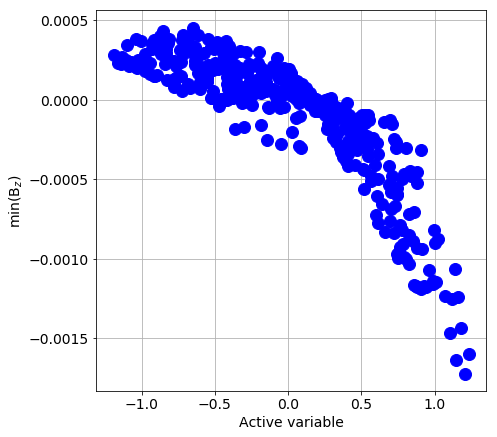

In [7]:
# active variable values associated with X
y = np.dot(XX, ss.W1)

#plots of response (pressure) vs. active variable
ac.utils.plotters.sufficient_summary(y, F, r"min(B$_z$)")

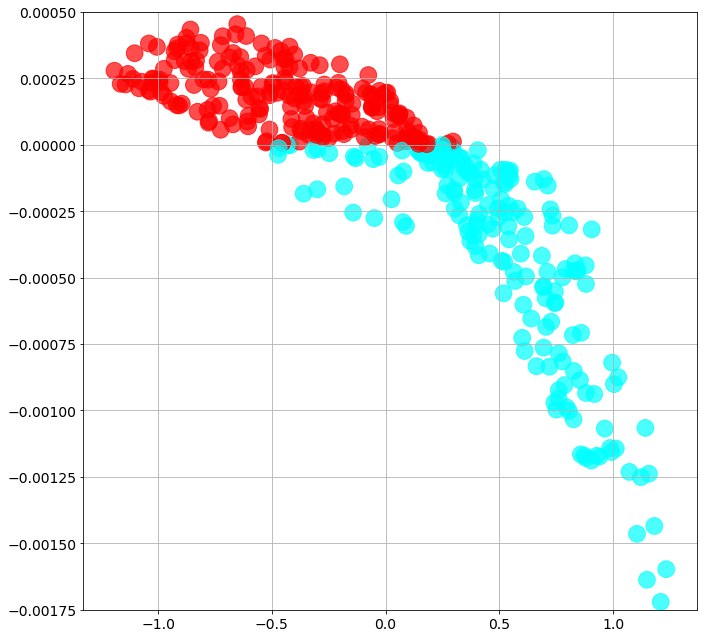

In [8]:
plt.figure(figsize=(11,11))
plt.scatter(y, F, c=frc[:,11], cmap=ListedColormap(('red', 'cyan')), alpha=0.7,s=280)
plt.ylim((-1.75e-3, 0.5e-3))
plt.grid(True)

Let's try a polynomial fit.

In [9]:
poly_reg = PolynomialFeatures(degree = 4)
y_poly = poly_reg.fit_transform(y)

lin_reg = LinearRegression()
lin_reg.fit(y_poly, F)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
rval = r2_score(F,lin_reg.predict(poly_reg.fit_transform(y) ))

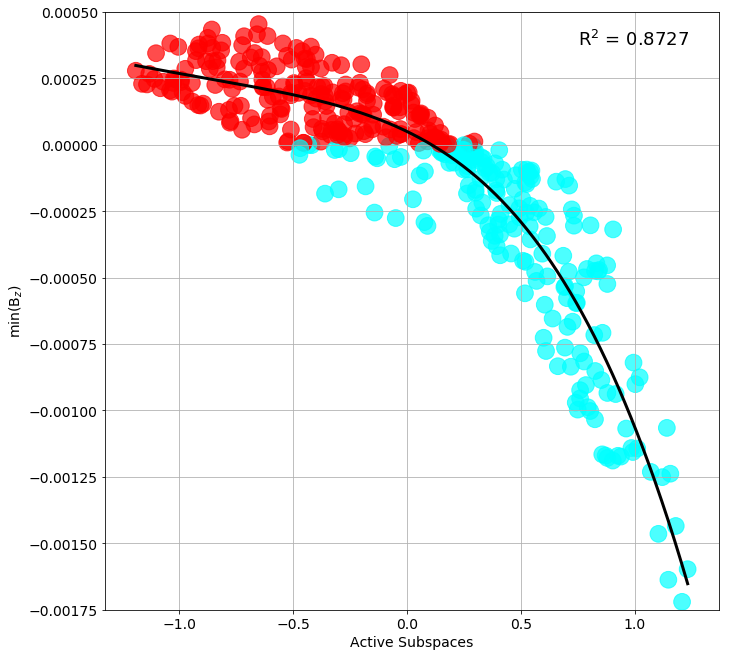

In [11]:
# Visualize the linear and polynomial regression results
plt.figure(figsize=(11,11))
plt.scatter(y, F, c=frc[:,11], cmap=ListedColormap(('red', 'cyan')), alpha=0.7,s=280)
plt.ylim((-1.75e-3, 0.5e-3))
plt.grid(True)

X_grid = np.linspace(min(y), max(y), 1000)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid, lin_reg.predict(poly_reg.fit_transform(X_grid)), color='black', label='polynomial regression', lw=3)

plt.xlabel("Active Subspaces")
plt.ylabel(r"min(B$_z$)")
plt.text(0.75,.000375,r"R$^2$ = "+str(round(rval,4)),fontsize=18,color='black')
plt.savefig("frc_active_subspaces_withBomegaOmegaTe.png", dpi=300)

In [12]:
in_labels = df.keys()[:3]

In [13]:
""" Display the components of w. 
The components of w tell us how sensitive the quantity of interest is to each parameter."""
print np.hstack((np.round(ss.W1, 4), in_labels[:,np.newaxis]))

[[0.3428          omega          ]
 [0.9321          Bomega         ]
 [0.1167          Te             ]]


# Using non-dimensional parameters gamma and lambda

In [14]:
# Separate the data into inputs (X) from outputs (F)
newX = frc[:,3:5]

# normalize each of the input parameters to the interval [-1, 1]
xl = np.array([min(frc[:,3]), min(frc[:,4])])
xu = np.array([max(frc[:,3]), max(frc[:,4])])
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(newX)

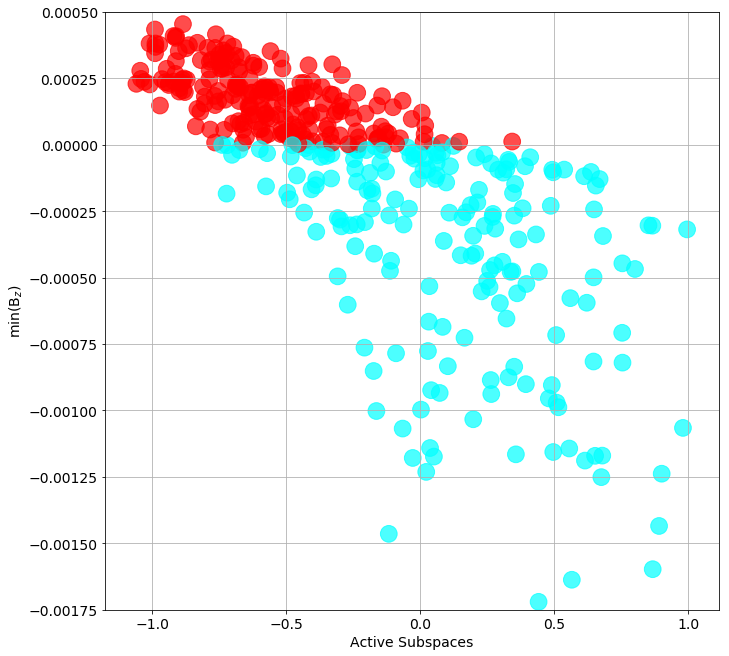

In [15]:
# Set up our subspace.
ss2 = ac.subspaces.Subspaces()

#Compute OLS subspaces
ss2.compute(X=XX, f=F[:,np.newaxis], sstype='OLS', nboot=500)

# active variable values associated with X
y2 = np.dot(XX, ss2.W1)

#plots of response
plt.figure(figsize=(11,11))
plt.scatter(y2, F, c=frc[:,11], cmap=ListedColormap(('red', 'cyan')), alpha=0.7,s=280)
plt.ylim((-1.75e-3, 0.5e-3))
plt.grid(True)
plt.xlabel("Active Subspaces")
plt.ylabel(r"min(B$_z$)")
plt.savefig("frc_active_subspaces_withGammaAndLambda.png", dpi=300)